### Testing

This notebook applies scaling to pair of image and its corresponding homography.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, exists, expanduser
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image
from collections import defaultdict

# from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
# from relfm.utils.log import print_update, tqdm_iterator
from relfm.utils.visualize import show_images_with_keypoints, draw_kps_on_image, show_grid_of_images
# from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result
# from relfm.inference.r2d2_on_hpatches import configure_save_dir
from relfm.utils.geometry import apply_homography_to_keypoints

In [3]:
data_dir = join(REPO_PATH, "data/hpatches-sequences-release/")
sequences = glob(join(data_dir, "*"))
sequence = sequences[1]

In [4]:
sequence

'/home/lcur1325/projects/rotation-equivariant-lfm/data/hpatches-sequences-release/v_home'

In [5]:
img1_path = join(sequence, "1.ppm")
img2_path = join(sequence, "2.ppm")
H_path = join(sequence, "H_1_2")

In [6]:
img1 = Image.open(img1_path)
img2 = Image.open(img2_path)
H = np.loadtxt(H_path)

In [7]:
img1.size, img2.size

((1126, 845), (1126, 845))

### Test H without scaling

In [8]:
# define some random predictions: keypoints and descriptors
width, height = img1.size

num_kps = 10
desc_dim = 128
kp1 = np.stack(
    [
        np.random.uniform(0., width, num_kps),
        np.random.uniform(0., height, num_kps),
    ]
).T
des1 = np.random.randn(num_kps, desc_dim)

kp2 = np.stack(
    [
        np.random.uniform(0., width, num_kps),
        np.random.uniform(0., height, num_kps),
    ]
).T
des2 = np.random.randn(num_kps, desc_dim)

In [9]:
kp1_to_img2 = apply_homography_to_keypoints(kp1, H)

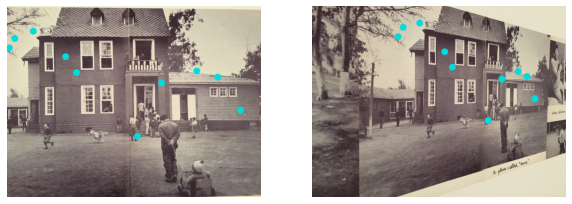

In [10]:
show_images_with_keypoints([img1, img2], [kp1, kp1_to_img2])

### Apply scaling to the image

In [11]:
imsize = 300

img1_resized = img1.resize((imsize, imsize))
img2_resized = img2.resize((imsize, imsize))

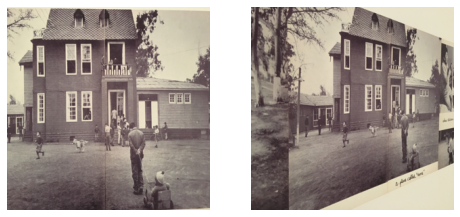

In [12]:
show_grid_of_images([img1_resized, img2_resized])

In [44]:
width, height = img1.size

In [50]:
width, height, imsize

(1126, 845, 300)

In [54]:
sx = imsize / width
sy = imsize / height

pad_axis = 1 if height > width else 0
pad_value = (height - imsize) if height > width else width - imsize
H_pad = np.eye(3)
H_pad[pad_axis, 2] = pad_value

# H_padx = np.array([
#     [1., 0., 0.],
#     [0., 1., 0.],
#     [0., 0., 1.],
# ])
# H_pad = 

H_for_scaling = np.array([
    [sx, 0., 0.],
    [0., sy, 0.],
    [0., 0., 1.],
])



# H_for_scaling[pad_axis, ]

In [69]:
H_for_scaling @ H_pad

array([[  0.26642984,   0.        , 220.07104796],
       [  0.        ,   0.35502959,   0.        ],
       [  0.        ,   0.        ,   1.        ]])

In [55]:
H_pad

array([[  1.,   0., 826.],
       [  0.,   1.,   0.],
       [  0.,   0.,   1.]])

In [56]:
H_for_scaling

array([[0.26642984, 0.        , 0.        ],
       [0.        , 0.35502959, 0.        ],
       [0.        , 0.        , 1.        ]])

In [57]:
H

array([[ 1.1943e+00,  1.0001e-02,  3.7277e+02],
       [ 2.2686e-01,  1.0937e+00, -6.7914e+01],
       [ 5.8802e-04,  5.2037e-05,  9.9941e-01]])

In [78]:
# H_scaled =  H_pad @ H_for_scaling @ H.copy() 
H_scaled = H_for_scaling @ H.copy() @ np.linalg.inv(H_for_scaling)

In [79]:
H_scaled

array([[ 1.19430000e+00,  7.50519094e-03,  9.93170515e+01],
       [ 3.02301018e-01,  1.09370000e+00, -2.41114793e+01],
       [ 2.20703507e-03,  1.46570883e-04,  9.99410000e-01]])

In [80]:
# define some random predictions: keypoints and descriptors
width, height = img1_resized.size

num_kps = 10
desc_dim = 128
kp1 = np.stack(
    [
        np.random.uniform(0., width, num_kps),
        np.random.uniform(0., height, num_kps),
    ]
).T

In [81]:
kp1_to_img2 = apply_homography_to_keypoints(kp1, H_scaled)

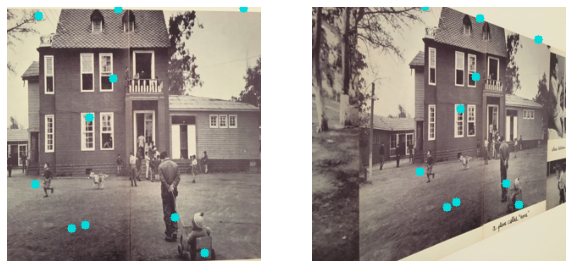

In [82]:
show_images_with_keypoints([img1_resized, img2_resized], [kp1, kp1_to_img2], radius=5)

In [75]:
kp1_to_img2

array([[603.89835669, 130.95452556],
       [493.45436807, 164.81545436],
       [421.44966815, 200.88504899],
       [513.17184095, 206.94023916],
       [435.60926015, 168.24477802],
       [584.71099516, 252.77136079],
       [485.0945484 ,  68.21454912],
       [578.30272878,  71.42132519],
       [555.9033008 , 191.35893456],
       [580.77922347, 141.29164205]])

In [20]:
H

array([[ 1.1943e+00,  1.0001e-02,  3.7277e+02],
       [ 2.2686e-01,  1.0937e+00, -6.7914e+01],
       [ 5.8802e-04,  5.2037e-05,  9.9941e-01]])

In [117]:
kp1_resized = apply_homography_to_keypoints(kp1, H_for_scaling)
kp1_to_img2_on_kp1_resized = apply_homography_to_keypoints(kp1_resized, H)

kp1_to_img2 = apply_homography_to_keypoints(kp1_resized, np.linalg.inv(H_for_scaling) @ H_scaled)

In [118]:
kp1_resized

array([[ 70.04711224, 180.35083767],
       [  6.0015214 , 128.04764182],
       [103.50182662, 201.37435825],
       [ 76.65519924, 228.34908644],
       [ 65.06658142, 144.61177238],
       [105.91498576,  96.0643596 ],
       [255.06304439, 146.68506263],
       [293.63367526, 100.31870955],
       [128.55493061, 118.77064962],
       [222.01179775, 208.45002066]])

In [119]:
kp1_to_img2

array([[436.41707528, 138.31315177],
       [377.59249161,  72.79422413],
       [465.46453218, 164.19290207],
       [441.7052508 , 188.59101096],
       [432.38344523, 100.46817907],
       [468.95111191,  57.35454476],
       [586.72773794, 129.97042103],
       [615.3609462 ,  92.09120453],
       [487.88300751,  84.30524943],
       [561.01058835, 184.46051509]])

In [120]:
kp1_to_img2_on_kp1_resized

array([[436.41707528, 138.31315177],
       [377.59249161,  72.79422413],
       [465.46453218, 164.19290207],
       [441.7052508 , 188.59101096],
       [432.38344523, 100.46817907],
       [468.95111191,  57.35454476],
       [586.72773794, 129.97042103],
       [615.3609462 ,  92.09120453],
       [487.88300751,  84.30524943],
       [561.01058835, 184.46051509]])

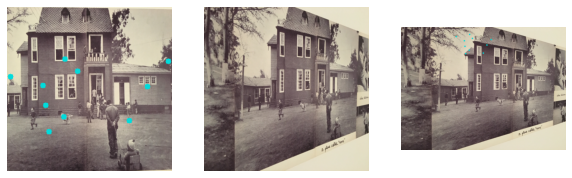

In [121]:
show_images_with_keypoints(
    [img1_resized, img2_resized, img2], [kp1_resized, kp1_to_img2, kp1_to_img2_on_kp1_resized], radius=5,
)

In [62]:
H_scaled

array([[ 3.18197158e-01,  2.66456483e-03,  9.93170515e+01],
       [ 8.05420118e-02,  3.88295858e-01, -2.41114793e+01],
       [ 5.88020000e-04,  5.20370000e-05,  9.99410000e-01]])